# Interação intermolecular entre duas moléculas de água

Neste exercício, você realizará a mesma análise que fizemos com o método supermolecular e vamos obter a energia de interação SAPT0 entre duas molélculas de água. Vamos utilizar o dímero de água com a seguinte geometria molecular:
![image](water_dimer.png)

In [2]:
import sys; sys.path.append("/usr/lib/x86_64-linux-gnu/") 
import time
import numpy as np
import scipy
from scipy.optimize import *
np.set_printoptions(precision=5, linewidth=200, threshold=2000, suppress=True)
import psi4
import matplotlib.pyplot as plt

# Set Psi4 & NumPy Memory Options
psi4.set_memory('1 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2

psi4.set_options({'basis': 'aug-cc-pVDZ',
              'e_convergence': 1e-10,
              'd_convergence': 1e-10,
              'INTS_TOLERANCE': 1e-15})


  Memory set to 953.674 MiB by Python driver.


Vamos escolher as mesmas distâncias

In [3]:
distances_h2o = [2.0,2.7,2.8,2.9,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0]

eelst = np.zeros((14))
eexch = np.zeros((14))
eind = np.zeros((14))
edisp = np.zeros((14))
esapt = np.zeros((14))


for i in range(len(distances_h2o)):
  dimero_H2O = psi4.geometry("""
  O1
  H1 O1 0.96
  H2 O1 0.96 H1 104.5
  --
  O2 O1 """+str(distances_h2o[i])+""" H1 5.0 H2 0.0
  X O2 1.0 O1 120.0 H2 180.0
  H3 O2 0.96 X 52.25 O1 90.0
  H4 O2 0.96 X 52.25 O1 -90.0
  units angstrom
  symmetry c1
  """)
  

  # calcula a energia
  psi4.energy('sapt0')
  eelst[i] = psi4.variable('SAPT ELST ENERGY') * 627.509
  eexch[i] = psi4.variable('SAPT EXCH ENERGY') * 627.509
  eind[i] = psi4.variable('SAPT IND ENERGY') * 627.509
  edisp[i] = psi4.variable('SAPT DISP ENERGY') * 627.509
  esapt[i] = psi4.variable('SAPT TOTAL ENERGY') * 627.509
 
 

  psi4.core.clean()


Agora vamos plotar as curvas SAPT

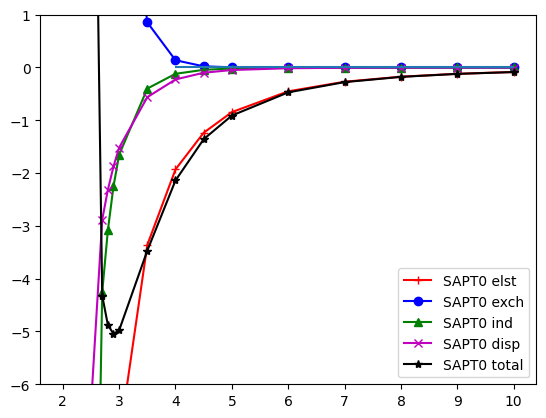

In [4]:
plt.close()
plt.ylim(-6.0,1.0)
plt.plot(distances_h2o,eelst,'r+',linestyle='-',label='SAPT0 elst')
plt.plot(distances_h2o,eexch,'bo',linestyle='-',label='SAPT0 exch')
plt.plot(distances_h2o,eind,'g^',linestyle='-',label='SAPT0 ind')
plt.plot(distances_h2o,edisp,'mx',linestyle='-',label='SAPT0 disp')
plt.plot(distances_h2o,esapt,'k*',linestyle='-',label='SAPT0 total')
plt.hlines(0.0,4.0,10.0)
plt.legend(loc='best')
plt.show()

*Questionamentos* 
1. Qual é a origem da atração entre as duas moléculas de água na orientação selecionada?
2. Para os termos que são de longo alcance e decaem com $R$ com uma lei de potência do tipo $R^{-n}$, estime $n$ ajustando a função adequada sobre os ultimos cinco pontos com os maiores valores de $R$, como fizemos no caso dos átomos de Hélio interagindo (usando o `scipy.optimize.curve_fit` ). Como explicariamos a potência de $n$ para a energia eletrostática?

Para responder a segunda pergunta, vamos pegar os últimos cinco valores de energia e ajustar a função $w(R)=-\frac{C_{elst}}{R^{6}}$ para os termos de longo-alcance, $E_{disp}$, $E_{ind}$ e $E_{elst}$. Se todos seguirem os modelos simples de interação de London, Debye e Kesson os expoentes deve ser próximos de $n=6$. Vamos verificar!

O expoente da lei de Potências é: 6.402730248212857
O coeficiente de dispersão é: 1381.390078411548
O valor de y0 é: -4.836771604984302e-05


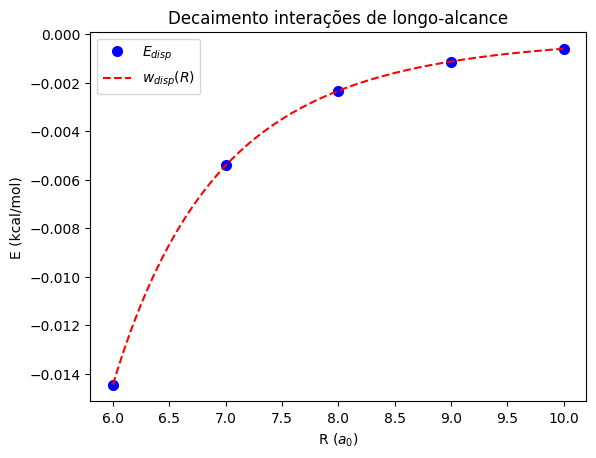

In [5]:
#COMPLETE the definition of function f below.
def f1(x,n,C,y0):
    return -(C)*(x**(-n))+y0


ndisp = scipy.optimize.curve_fit(f1,distances_h2o[-5:],edisp[-5:])

# Data
R = distances_h2o[-5:]
Edisp = edisp[-5:]

# Fit the function
popt, pcov = curve_fit(f1, R, Edisp)

# Print the value of n
print(f"O expoente da lei de Potências é: {popt[0]}")
print(f"O coeficiente de dispersão é: {popt[1]}")
print(f"O valor de y0 é: {popt[2]}")

# Plot the data points
plt.plot(R, Edisp, 'o', markersize=7, color='blue', label='$E_{disp}$')

# Plot the fitted function
x_fit = np.linspace(6, 10, 100)
y1_fit = f1(x_fit, popt[0], popt[1], popt[2])
plt.plot(x_fit, y1_fit, '--', color='red', label='$w_{disp}(R)$')


# Set the labels and title of the plot
plt.xlabel('R ($a_0$)')
plt.ylabel('E (kcal/mol)')
plt.title('Decaimento interações de longo-alcance')

# Show the plot
plt.legend()
plt.show()

Optimal induction exponent: 6.635508851981195
O expoente da lei de Potências é: 6.635508851981195
O coeficiente de indução é: 775.6108013225544
O valor de y0 é: -4.7895291262840054e-05


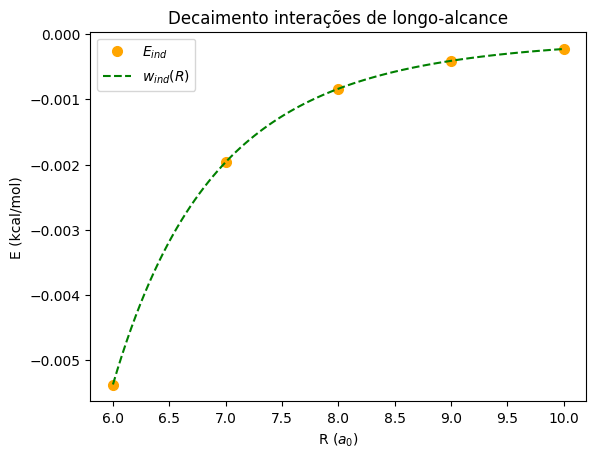

In [6]:
#COMPLETE the definition of function f below.
def f2(x,n,C,y0):
    return -(C)*(x**(-n))+y0


nind = scipy.optimize.curve_fit(f2,distances_h2o[-5:],eind[-5:])
print ("Optimal induction exponent:",nind[0][0])

# Data
R = distances_h2o[-5:]
Eind = eind[-5:]

# Fit the function
popt, pcov = curve_fit(f1, R, Eind)

# Print the value of n
print(f"O expoente da lei de Potências é: {popt[0]}")
print(f"O coeficiente de indução é: {popt[1]}")
print(f"O valor de y0 é: {popt[2]}")

# Plot the data points
plt.plot(R, Eind, 'o', markersize=7, color='orange', label='$E_{ind}$')

# Plot the fitted function
x_fit = np.linspace(6, 10, 100)
y2_fit = f1(x_fit, popt[0], popt[1], popt[2])
plt.plot(x_fit, y2_fit, '--', color='green', label='$w_{ind}(R)$')


# Set the labels and title of the plot
plt.xlabel('R ($a_0$)')
plt.ylabel('E (kcal/mol)')
plt.title('Decaimento interações de longo-alcance')

# Show the plot
plt.legend()
plt.show()

Optimal electrostatics exponent: 3.3990909797397975
O expoente da lei de Potências é: 3.3990909797397975
O coeficiente de dispersão é: 195.94235001136374
O valor de y0 é: -0.007680838021937547


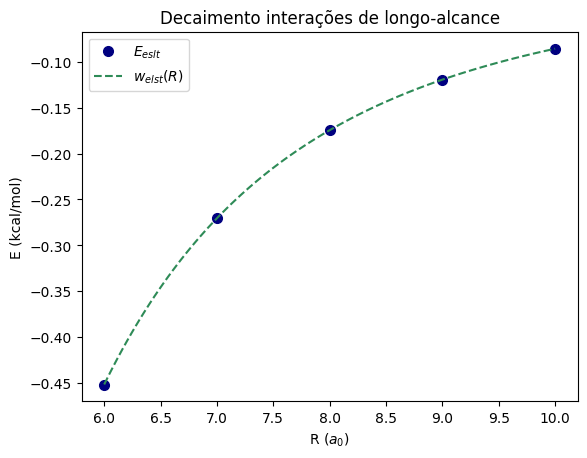

In [7]:
#COMPLETE the definition of function f below.
def f3(x,n,C,y0):
    return -(C)*(x**(-n))+y0


nelst = scipy.optimize.curve_fit(f2,distances_h2o[-5:],eelst[-5:])
print ("Optimal electrostatics exponent:",nelst[0][0])

# Data
R = distances_h2o[-5:]
Eelst = eelst[-5:]

# Fit the function
popt, pcov = curve_fit(f1, R, Eelst)

# Print the value of n
print(f"O expoente da lei de Potências é: {popt[0]}")
print(f"O coeficiente de dispersão é: {popt[1]}")
print(f"O valor de y0 é: {popt[2]}")

# Plot the data points
plt.plot(R, Eelst, 'o', markersize=7, color='navy', label='$E_{eslt}$')

# Plot the fitted function
x_fit = np.linspace(6, 10, 100)
y3_fit = f3(x_fit, popt[0], popt[1], popt[2])
plt.plot(x_fit, y3_fit, '--', color='seagreen', label='$w_{elst}(R)$')


# Set the labels and title of the plot
plt.xlabel('R ($a_0$)')
plt.ylabel('E (kcal/mol)')
plt.title('Decaimento interações de longo-alcance')

# Show the plot
plt.legend()
plt.show()

A molécula de água é polar - cada uma tem um momento de dipolo não-nulo e em grandes distâncias esperamos que a energia eletrostática seja dominada pela interação dipolo-dipolo (em distâncias mais curtas, quando os orbitais das duas moléculas começam a se superpor, a aproximação multipolar não é mais válida e a eenrgia eletrostática contém um termo de curto-alcance chamado de *penetração de carga*). Vamos checar se isto é de fato o caso. Na preparação para esta análise, iremos primeiro, encontrar o vetor de momento de dipolo de cada molécula de água no nível HF.

In [8]:
waterA = psi4.geometry("""
O 0.116724185090 1.383860971547 0.000000000000
H 0.116724185090 0.423860971547 0.000000000000
H -0.812697549673 1.624225775439 0.000000000000
units angstrom
noreorient
nocom
symmetry c1
""")

comA = waterA.center_of_mass()
comA = np.array([comA[0],comA[1],comA[2]])
E, wfn = psi4.energy('HF',return_wfn=True)
dipoleA = np.array([psi4.variable('SCF DIPOLE X'),psi4.variable('SCF DIPOLE Y'),
                    psi4.variable('SCF DIPOLE Z')])*0.393456   # conversion from Debye to a.u.
psi4.core.clean()
print("COM A in a.u.",comA)
print("Dipole A in a.u.",dipoleA)

waterB = psi4.geometry("""
O -0.118596320329 -1.305864713301 0.000000000000
H 0.362842754701 -1.642971982825 -0.759061990794
H 0.362842754701 -1.642971982825 0.759061990794
units angstrom
noreorient
nocom
symmetry c1
""")

comB = waterB.center_of_mass()
comB = np.array([comB[0],comB[1],comB[2]])
E, wfn = psi4.energy('HF',return_wfn=True)
dipoleB = np.array([psi4.variable('SCF DIPOLE X'),psi4.variable('SCF DIPOLE Y'),
                    psi4.variable('SCF DIPOLE Z')])*0.393456   # conversion from Debye to a.u.
psi4.core.clean()
print("COM B in a.u.",comB)
print("Dipole B in a.u.",dipoleB)

comA_to_comB = comB - comA
print("Vector from COMA to COMB:",comA_to_comB)

COM A in a.u. [0.1223  2.53902 0.     ]
Dipole A in a.u. [-0.62255 -0.48203  0.     ]
COM B in a.u. [-0.1223  -2.53902  0.     ]
Dipole B in a.u. [ 0.64496 -0.45161 -0.     ]
Vector from COMA to COMB: [-0.24459 -5.07804  0.     ]


Nosso objetivo agora é plotar a energia eletrostática do SAPT em função da energia de interação entre dois dipolos $\boldsymbol{\mu_A}$ e $\boldsymbol{\mu_B}$:

\begin{equation}
E_{\rm dipole-dipole}=\frac{\boldsymbol{\mu_A}\cdot\boldsymbol{\mu_B}}{R^3}-\frac{3(\boldsymbol{\mu_A}\cdot{\mathbf R})(\boldsymbol{\mu_B}\cdot{\mathbf R})}{R^5} 
\end{equation}

Vamos programar esta fórmula na função `dipole_dipole` abaixo, empregando ${\mathbf R}$, $\boldsymbol{\mu_A}$, e $\boldsymbol{\mu_B}$ em unidades atômicas e Calculamos a energia de interação dipolo-dipolo, também em unidades atômicas (que converteremos posteriormente para kcal/mol). 
Com sua nova função, podemos popular o `edipdip` array das energias de interação dipolo-dipolo para todas as separações intermoleculares, e plotar estas energias junto com a verdadeira energia de interação eletrostática obtida com o método SAPT. 

Note que ${\mathbf R}$ é o vetor do centro de massa da molécula A para o centro de massa da molécula B. Para a menor distância intermolecular, as coordenadas atômicas são listadas no cídigo acima, `R = comA_to_comB`. Para qualquer outra distância, nós obtemos a geometria do complexo deslocando uma molécula de água para longe da outra ao longo da direção O-O, então precisamos deslocar o centro de massa da segunda molécula da mesma forma.

In [28]:
import numpy as np
#the geometries are related to each other by a shift of 1 molecule along the O-O vector:
OA_to_OB = (np.array([-0.118596320329,-1.305864713301,0.000000000000])-np.array(
    [0.116724185090,1.383860971547,0.000000000000]))/0.529177249
OA_to_OB_unit = OA_to_OB/np.sqrt(np.sum(OA_to_OB*OA_to_OB))
print("Vector from OA to OB:",OA_to_OB,OA_to_OB_unit)

def dipole_dipole(R,dipA,dipB):
  (dipA*dipB/R)-((3*(dipA*R)*(dipB*R))/R**6)


edipdip = []
for i in range(len(distances_h2o)):
  shiftlength = (distances_h2o[i]-distances_h2o[0])/0.529177249
  R = comA_to_comB + shiftlength*OA_to_OB_unit
  edipdip.append(dipole_dipole(R,dipoleA,dipoleB)*627.509)

edipdip = np.array(edipdip)
print (edipdip)

plt.close()
plt.ylim(-10.0,10.0)
plt.plot(distances_h2o,eelst,'r+',linestyle='-',label='SAPT0 elst')
plt.plot(distances_h2o,edipdip,'bo',linestyle='-',label='dipole-dipole')
plt.hlines(0.0,2.5,9.0)
plt.legend(loc='upper right')
plt.show()

Vector from OA to OB: [-0.44469 -5.08284  0.     ] [-0.08716 -0.99619  0.     ]


/tmp/ipykernel_581/2441878908.py:9: RuntimeWarning: divide by zero encountered in divide
  (dipA*dipB/R)-((3*(dipA*R)*(dipB*R))/R**6)
/tmp/ipykernel_581/2441878908.py:9: RuntimeWarning: invalid value encountered in divide
  (dipA*dipB/R)-((3*(dipA*R)*(dipB*R))/R**6)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

Vemos claramente que a interação dipolo-dipolo é favorável, que resulta da energia eletrostática negativa (atrativa). Assim é como as origens da ligação de hidrogênio pode ser explicada em cursos introdutórios de Química Geral: duas moléculas polares tem momentos de dipolos não-nulos e a interação dipolo-dipolo pode ser fortemente atrativa. Entretanto, suas componentes SAPT te mostram que esta não é uma explicação completa. As duas moléculas de água formam o complexo ligados não apenas por interações eletrostáticas, mas pelas outras duas componentes SAPT também! Você conseguiria quantificar a contribuição relativa percentual das componentes $E_{disp}$, $E_{ind}$ e $E_{elst}$ em relação a energia de interação total $E_{SAPT}$ no mínimo da curva de energia potencial? Este mínimo é o terceiro ponto de sua curva, então por exemplo,  `esapt_h2o[2]` é a energia total de interação SAPT.


In [19]:
#now let's examine the SAPT0 contributions at the van der Waals minimum, which is the 2nd point on the curve
#COMPLETE the calculation of percentages.
percent_elst = (eelst[3]/(eelst[3]+eind[3]+edisp[3]))*100
percent_ind  = (eind[3]/(eelst[3]+eind[3]+edisp[3]))*100
percent_disp = (edisp[3]/(eelst[3]+eind[3]+edisp[3]))*100
print ('No mínimo da curva de energia potencial, as componentes eletrostáticas, indução, e dispersão')
print (' contribuem %5.1f, %5.1f, e %5.1f porcento na energia total de interação, respectivamente.'
 % (percent_elst,percent_ind,percent_disp))

No mínimo da curva de energia potencial, as componentes eletrostáticas, indução, e dispersão
 contribuem  67.2,  17.9, e  14.9 porcento na energia total de interação, respectivamente.


# Diagramas Ternários

Níveis superiores de cálculos SAPT podem fornecer energias de interação muito precisas, mas são computacionalmente mais onerosas do que SAPT0. SAPT0 é normalmente suficiente para análises qualitativas e entendimento básico da física de interação. Um uso importante do SAPT0 é para *classificar diferentes complexos intermoleculares de acordo com o tipo de interação* e uma boa forma de mostrar os resultados desta classificação é através do uso de um *diagrama ternário*.

A importância relativa das contribuições eletrostáticas, de indução e de dispersão para a energia de interação SAPT para uma estrutura particualr pode ser marcado como um ponto dentro de um triângulo, cuja distância para cada vértice do triângulo descreve a contribuição relativa de uma certa componente energérica (quanto mais dominte ela for, mais próximo o ponto estatá deste vértice correspondente). Se a contribuição eletrostática é repulsiva, podemos mostrar as magnitudes relativas dos termos eletrostáticos, indução e dispersão da mesma forma, mas precisamos de um segundo triângulo. A combinação de dois triângulos forma o diagrama completo e podemos marcar diversos pontos diferentes correspondendo a diferentes complexos e geometrias.

Vamos agora marcar todos nossos sistemas em um diagrama ternário, em azul para dois átomos de Hélio e em vermelho para duas moléculas de água. Quais tipos de interação estão representadas? Compare seu diagrama com o apresentado abaixo preparado para 2510 geometrias diferentes do complexo de duas moléculas de água com todos os tipos de distâncias e orientações (este gráfico foi extraído de [Smith:2016]). Quais conclusões podemos extrair da interação de duas moléculas de água em *qualquer* orientação?


In [20]:
distances_he = [4.0,4.5,5.0,5.3,5.6,6.0,6.5,7.0,8.0,9.0,10.0]
eelst_he = np.zeros((11))
eexch_he = np.zeros((11))
eind_he = np.zeros((11))
edisp_he = np.zeros((11))
esapt_he = np.zeros((11))

for i in range(len(distances_he)):
  dimer_he = psi4.geometry("""
  He 0.0 0.0 0.0
  --
  He 0.0 0.0 """+str(distances_he[i])+"""
  units bohr
  symmetry c1
  """)

  psi4.energy('sapt0')
  eelst_he[i] = psi4.variable('SAPT ELST ENERGY') * 627.509
  eexch_he[i] = psi4.variable('SAPT EXCH ENERGY') * 627.509
  eind_he[i] = psi4.variable('SAPT IND ENERGY') * 627.509
  edisp_he[i] = psi4.variable('SAPT DISP ENERGY') * 627.509
  esapt_he[i] = psi4.variable('SAPT TOTAL ENERGY') * 627.509
  psi4.core.clean()


In [27]:
def ternary(sapt, title='', labeled=True, view=True, saveas=None, relpath=False, graphicsformat=['pdf']):
#Adapted from the QCDB ternary diagram code by Lori Burns
    """Takes array of arrays *sapt* in form [elst, indc, disp] and builds formatted
    two-triangle ternary diagrams. Either fully-readable or dotsonly depending
    on *labeled*.
    """
    from matplotlib.path import Path
    import matplotlib.patches as patches

    # initialize plot
    plt.close()
    fig, ax = plt.subplots(figsize=(6, 3.6))
    plt.xlim([-0.75, 1.25])
    plt.ylim([-0.18, 1.02])
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect('equal')

    if labeled:
        # form and color ternary triangles
        codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
        pathPos = Path([(0., 0.), (1., 0.), (0.5, 0.866), (0., 0.)], codes)
        pathNeg = Path([(0., 0.), (-0.5, 0.866), (0.5, 0.866), (0., 0.)], codes)
        ax.add_patch(patches.PathPatch(pathPos, facecolor='white', lw=2))
        ax.add_patch(patches.PathPatch(pathNeg, facecolor='#fff5ee', lw=2))

        # label corners
        ax.text(1.0,
                -0.15,
                u'Elst (−)',
                verticalalignment='bottom',
                horizontalalignment='center',
                family='serif',
                weight='bold',
                fontsize=18)
        ax.text(0.5,
                0.9,
                u'Ind (−)',
                verticalalignment='bottom',
                horizontalalignment='center',
                family='serif',
                weight='bold',
                fontsize=18)
        ax.text(0.0,
                -0.15,
                u'Disp (−)',
                verticalalignment='bottom',
                horizontalalignment='center',
                family='serif',
                weight='bold',
                fontsize=18)
        ax.text(-0.5,
                0.9,
                u'Elst (+)',
                verticalalignment='bottom',
                horizontalalignment='center',
                family='serif',
                weight='bold',
                fontsize=18)

    xvals = []
    yvals = []
    cvals = []
    geomindex = 0 # first 11 points are He-He, the next 10 are H2O-H2O
    for sys in sapt:
        [elst, indc, disp] = sys

        # calc ternary posn and color
        Ftop = abs(indc) / (abs(elst) + abs(indc) + abs(disp))
        Fright = abs(elst) / (abs(elst) + abs(indc) + abs(disp))
        xdot = 0.5 * Ftop + Fright
        ydot = 0.866 * Ftop
        if geomindex <= 10:
          cdot = 'b'
        else:
          cdot = 'r'
        if elst > 0.:
            xdot = 0.5 * (Ftop - Fright)
            ydot = 0.866 * (Ftop + Fright)
        #print elst, indc, disp, '', xdot, ydot, cdot

        xvals.append(xdot)
        yvals.append(ydot)
        cvals.append(cdot)
        geomindex += 1

    sc = ax.scatter(xvals, yvals, c=cvals, s=15, marker="o", 
                    edgecolor='none', vmin=0, vmax=1, zorder=10)

    # remove figure outline
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # save and show
    plt.show()
    return 1

sapt = []
for i in range(11):
  sapt.append([eelst_he[i],eind_he[i],edisp_he[i]])
for i in range(10):
  sapt.append([eelst[i],eind[i],edisp[i]])
idummy = ternary(sapt)


<IPython.core.display.Javascript object>

/tmp/ipykernel_581/879553143.py:87: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = ax.scatter(xvals, yvals, c=cvals, s=15, marker="o",


Esta imagem foi extraída do artigo *J. Phys. Chem. Lett.* 2016, 7, 12, 2197–2203


![image](water2510.png)